In [0]:
import pandas as pd
import numpy as np

In [0]:
!mkdir dataset

In [0]:
!mv 15features.csv dataset/

In [0]:
!pip install pgmpy
!pip install 'matplotlib <= 2.2.3'

In [2]:
data = pd.read_csv("./dataset/15features.csv")
data["imagename"] = data.imagename.str.split("[a-z]",expand=True)
data.head()

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


In [0]:
from pgmpy.estimators import HillClimbSearch, K2Score
import networkx as nx
import pylab as plt

In [0]:
def genPositiveData(data):
    skeleton = pd.DataFrame()
    writers = np.unique(data.imagename)
    for writer in writers:
        query = str("imagename == '"+str(writer)+"'")
        test = data.query(str(query))
        data1 = test.sample(frac=1)
        data1 = data1.add_prefix('w1_')
        data2 = test.sample(frac=1)
        data2 = data2.add_prefix('w2_')
        temp = pd.concat([data1.reset_index(drop=True),data2.reset_index(drop=True)],axis=1)
        skeleton = skeleton.append(temp)
    return skeleton

def genNegativeData(data):
    data1 = data.sample(frac=1)
    data1 = data1.add_prefix('w1_')
    data2 = data.sample(frac=1)
    data2 = data2.add_prefix('w2_')
    negSamples = pd.concat([data1.reset_index(drop=True),data2.reset_index(drop=True)],axis=1)
    return negSamples

In [0]:
skeleton = pd.DataFrame()
posData = genPositiveData(data)
negData = genNegativeData(data)
temp = negData.append(posData).reset_index(drop=True)
skeleton = temp.append(skeleton)

In [0]:
bigBadDataset = skeleton

In [0]:
bigBadDataset["sameWriter"]=0

In [0]:
bigBadDataset.sameWriter  = np.where(bigBadDataset["w1_imagename"] == bigBadDataset["w2_imagename"],1,0)

In [0]:
bigBadDataset = bigBadDataset.drop(["w1_imagename","w2_imagename"],axis=1)

In [0]:
for columns in bigBadDataset.columns:
    if(columns != "sameWriter"):
        bigBadDataset[str(columns)] = bigBadDataset[str(columns)] - 1

In [13]:
sameWriterHypothesis = len(bigBadDataset.query('sameWriter == 1' )) / len(bigBadDataset)
print(sameWriterHypothesis)
diffWriterHypothesis = len(bigBadDataset.query('sameWriter == 0' )) / len(bigBadDataset)
print(diffWriterHypothesis)

0.5005895357406043
0.4994104642593957


In [0]:
bigBadDataset = bigBadDataset.sample(frac=1)
bigBadDataset.head().reset_index(drop=True)
trainData = bigBadDataset[0:int(np.floor(len(bigBadDataset)*0.8))]
testData = bigBadDataset[int(np.floor(len(bigBadDataset)*0.8)):]
trainData = trainData.reset_index(drop=True)
testData = testData.reset_index(drop=True)

In [15]:
sameWriterHypothesis = len(testData.query('sameWriter == 1' )) / len(testData)
print(sameWriterHypothesis)
diffWriterHypothesis = len(testData.query('sameWriter == 0' )) / len(testData)
print(diffWriterHypothesis)

0.4948415622697126
0.5051584377302873


In [0]:
est = HillClimbSearch(trainData, scoring_method=K2Score(trainData))
%time ssj2Model = est.estimate(max_indegree=2)

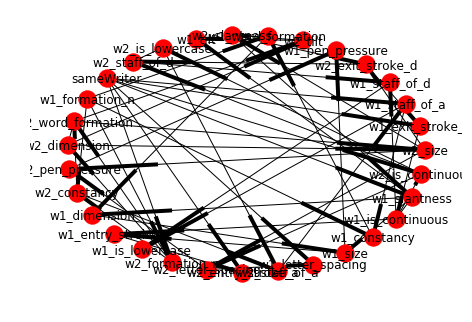

In [0]:
nx.draw(ssj2Model, with_labels=True)
plt.show()

In [0]:
ssj2Model.fit(trainData,complete_samples_only=True)

In [0]:
sameWriterPrediction = ssj2Model.predict(testData.iloc[:,0:30])

In [0]:
accuracy = 0
for row in range(len(sameWriterPrediction)):
    if sameWriterPrediction.sameWriter[row] == testData.sameWriter[row]:
        accuracy +=1

1

In [0]:
accuracy/len(testData)

0.7406042741341193

In [0]:
from pgmpy.readwrite import BIFWriter

In [0]:
model_data = BIFWriter(ssj2Model)
model_data.write_bif(filename='ssj2Model.bif')

## Method 2

In [7]:
writers = data.imagename
rawData = data.iloc[:,1:]
rawData.head()

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


In [0]:
trainData = rawData[0:int(np.floor(len(rawData)*0.8))]
testData = rawData[int(np.floor(len(rawData)*0.8)):]

In [12]:
est = HillClimbSearch(trainData, scoring_method=K2Score(trainData))
%time revivalModel2 = est.estimate(max_indegree=2)

CPU times: user 49.3 s, sys: 231 ms, total: 49.5 s
Wall time: 49.6 s


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:138: Matplot

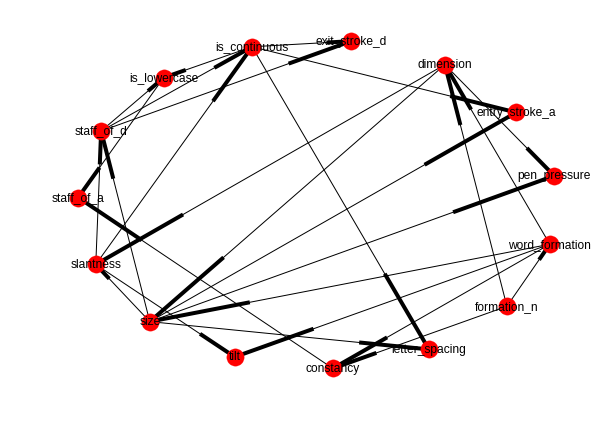

In [13]:
nx.draw(revivalModel2, with_labels=True)
plt.show()

In [0]:
from pgmpy.models import BayesianModel

In [15]:
est = HillClimbSearch(rawData, scoring_method=K2Score(rawData))
%time revivalModel2 = est.estimate(max_indegree=2)

<bound method Graph.nodes of <pgmpy.models.BayesianModel.BayesianModel object at 0x7f6376350c18>>


In [0]:
left = BayesianModel()

In [0]:
test =[]
for cols in trainData.columns:
  temp = str("left_"+cols)
  test.append(temp)

In [22]:
test

['apen_pressure',
 'aletter_spacing',
 'asize',
 'adimension',
 'ais_lowercase',
 'ais_continuous',
 'aslantness',
 'atilt',
 'aentry_stroke_a',
 'astaff_of_a',
 'aformation_n',
 'astaff_of_d',
 'aexit_stroke_d',
 'aword_formation',
 'aconstancy']

In [0]:
modelLeft.add_node('a')

In [0]:
modelLeft.add_nodes_from(modelRight)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:138: Matplot

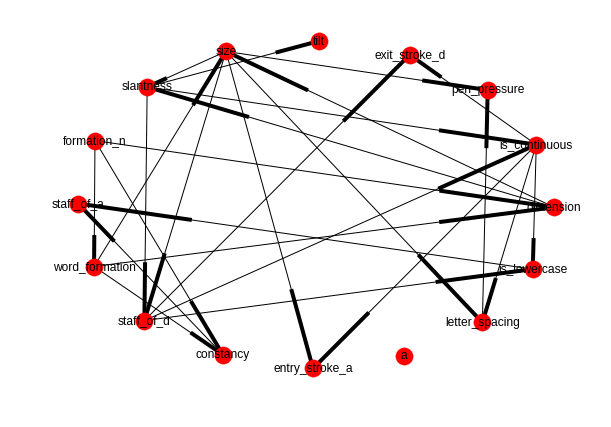

In [11]:
nx.draw(modelLeft, with_labels=True)
plt.show()

In [0]:
trainData = bigBadDataset[0:int(np.floor(len(bigBadDataset)*0.8))]
testData = bigBadDataset[int(np.floor(len(bigBadDataset)*0.8)):]
trainData = trainData.reset_index(drop=True)
testData = testData.reset_index(drop=True)

In [0]:
est = HillClimbSearch(trainData, scoring_method=K2Score(trainData))
ssj2Model = est.estimate(max_indegree=2)